## What is this notebook for?

This script is based on the histogram_analysis_example Jupyter notebook.

It applies the analysis on the MVPA data.

It is used to select the most important features. 

In [64]:
# TODO: Add component 2,3 and 4 of the MVPA data

#### Import libraries

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D
from function_reshape_array import reshape_array as ra

import os
import nibabel as nib
import time
from tpot import TPOTClassifier
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

### load data and reshape it

In [42]:
#%% filepath
# path to data
#  - on Windows: C:/Users/tahendry/Desktop/Masterthesis_Reto/
#  - on Linux:   ../data/

try:
    print(os.uname())
    data_path = "../data/"
except:
    print("Windows")
    data_path = "C:/Users/tahendry/Desktop/Masterthesis_Reto/"

posix.uname_result(sysname='Linux', nodename='dalcowks', release='5.13.0-40-generic', version='#45~20.04.1-Ubuntu SMP Mon Apr 4 09:38:31 UTC 2022', machine='x86_64')


In [43]:
# read in the excel-file with the labels
label_file = "Conn_IDs_Matching.xlsx"

# read excel with only the first three columns
label_df = (pd.read_excel(os.path.join(data_path, label_file),
                            usecols=[0, 1, 2])
            .replace({"Cond": {1: 0}})
            .replace({"Cond": {2: 1}})
            )

label_df.head()

,Conn_SubjNr,VPNr,Cond
0,1,1,0
1,2,2,0
2,3,4,0
3,4,6,1
4,5,7,0


In [44]:
# read MVPA data
path_content = os.listdir(os.path.join(data_path, "Denoised_Data_6mm", "MVPA_data"))

# make two lists with pre (Condition002) and post (Condition003) data of first component
comp1_pre = sorted([x for x in path_content 
                    if "Component001" in x 
                    and "Condition002" in x])
comp1_post = sorted([x for x in path_content 
                    if "Component001" in x 
                    and "Condition003" in x])

print(comp1_pre[:5])

['BETA_Subject001_Condition002_Measure002_Component001.nii', 'BETA_Subject002_Condition002_Measure002_Component001.nii', 'BETA_Subject003_Condition002_Measure002_Component001.nii', 'BETA_Subject004_Condition002_Measure002_Component001.nii', 'BETA_Subject005_Condition002_Measure002_Component001.nii']


In [45]:
# create a dataset with the difference of pre and post data
comp1_diff = []
for pre, post in zip(comp1_pre, comp1_post):
    pre_vol = nib.load(os.path.join(data_path, "Denoised_Data_6mm", "MVPA_data", pre))
    post_vol = nib.load(os.path.join(data_path, "Denoised_Data_6mm", "MVPA_data", post))
    pre_vol_data = pre_vol.get_fdata()
    post_vol_data = post_vol.get_fdata()
    diff_vol_data = post_vol_data - pre_vol_data
    comp1_diff.append(diff_vol_data)

# check the shape of the data
print(comp1_diff[0].shape)

# check the type of the data
print(type(comp1_diff[0]))

# stack the data to later use it as input for the CNN
# note: the first dimension is the number of samples
print(f"shape of one list element before stacking: {comp1_diff[0].shape=}")
inpt_comp1_diff = np.stack(comp1_diff, axis=0)

# normalize the input data (zero mean, unit variance)
# note: a CNN works best with normalized data
inpt_comp1_diff = (inpt_comp1_diff - inpt_comp1_diff.mean()) / inpt_comp1_diff.std()

print(f"{inpt_comp1_diff.shape=}",
      f"{inpt_comp1_diff.mean()=}",
      f"{inpt_comp1_diff.std()=}", sep="\n")

(91, 109, 91)
<class 'numpy.ndarray'>
shape of one list element before stacking: comp1_diff[0].shape=(91, 109, 91)
inpt_comp1_diff.shape=(68, 91, 109, 91)
inpt_comp1_diff.mean()=1.2019033790773762e-16
inpt_comp1_diff.std()=0.9999999999999889


In [46]:
# create a 3d array
arr_big = inpt_comp1_diff
print(f"flattened length of big array: {len(arr_big.flatten())}",
      f"shape of big array: {arr_big.shape}",)

# reshape the array
reshape_factor = 5
arr_small = np.array([ra(arr_big[i], (reshape_factor, reshape_factor, reshape_factor)) 
                        for i in range(arr_big.shape[0])])

print(f"flattened length of small array: {len(arr_small.flatten())}",
      f"shape of small array: {arr_small.shape}",
      f"factor of reduction: {len(arr_big.flatten()) / len(arr_small.flatten())}")

flattened length of big array: 61378772 shape of big array: (68, 91, 109, 91)
flattened length of small array: 515508 shape of small array: (68, 19, 21, 19) factor of reduction: 119.0646352723915


<function matplotlib.pyplot.show(close=None, block=None)>

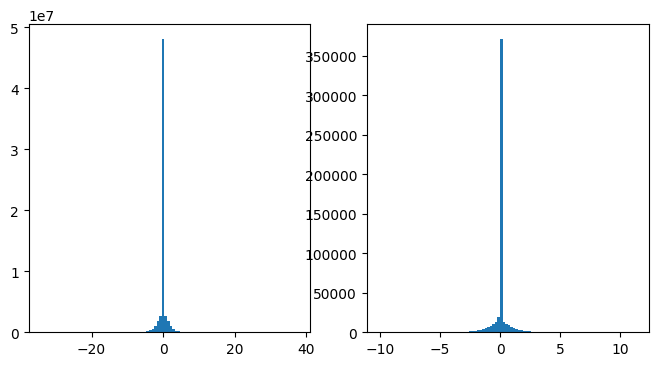

In [47]:
# plot histogram of big and small arr
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(121)
ax1.hist(arr_big.flatten(), bins=100)
ax2 = fig.add_subplot(122)
ax2.hist(arr_small.flatten(), bins=100)
plt.show

In [48]:
arr_small.shape

(68, 19, 21, 19)

#### ground truth array

In [49]:
# create GT array from label_df
arr_gt = np.array(label_df["Cond"])
arr_gt

array([0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0])

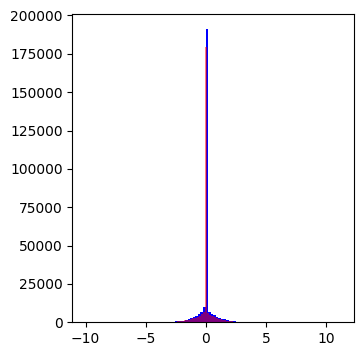

In [50]:
# plot histogram of arr_small, colors are different for 0 and 1
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(121)
ax.hist(arr_small[arr_gt == 0].flatten(), bins=100, color='blue')
ax.hist(arr_small[arr_gt == 1].flatten(), bins=100, color='red', alpha=0.5)
plt.show()

### manipulate data to see importance of a feature

In [51]:
# flatten the arr_small into a 2d array (keep the sample dimension)
arr_small_2d = arr_small.reshape(arr_small.shape[0], -1)
print(f"shape of arr_small_2d: {arr_small_2d.shape}")

shape of arr_small_2d: (68, 7581)


In [52]:
# create a histogram along the sample dimension 
df_small = (pd.DataFrame(arr_small_2d)
            # add a column "ground_truth" as categorical which contains the ground truth
            .assign(ground_truth=pd.Categorical(arr_gt))
            )
# df_small.hist(bins=100, figsize=(8, 4))
df_small

,0,1,2,3,4,5,6,7,8,9,...,7572,7573,7574,7575,7576,7577,7578,7579,7580,ground_truth
0,-0.000853,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,...,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.000853,0
1,-0.000853,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,...,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.000853,0
2,-0.000853,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,...,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.000853,0
3,-0.000853,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,...,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.000853,1
4,-0.000853,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,...,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.000853,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,-0.000853,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,...,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.000853,0
64,-0.000853,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,...,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.000853,0
65,-0.000853,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,...,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.000853,1
66,-0.000853,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,...,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.001421,-0.000853,1


<Axes: >

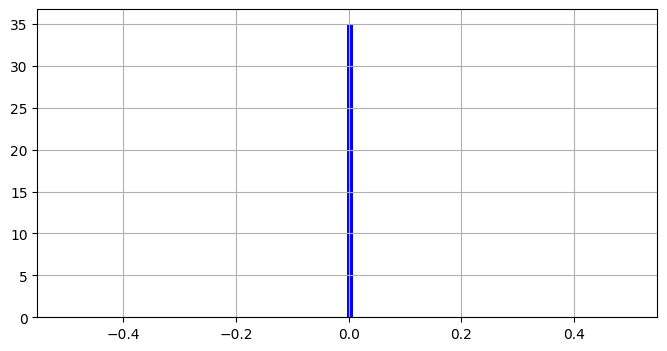

In [53]:
# create histogram for one column
col_nr = 490
df_small.loc[df_small["ground_truth"]==1 , col_nr].hist(bins=100, figsize=(8, 4), color='red')
df_small.loc[df_small["ground_truth"]==0 , col_nr].hist(bins=100, figsize=(8, 4), color='blue')


<Axes: >

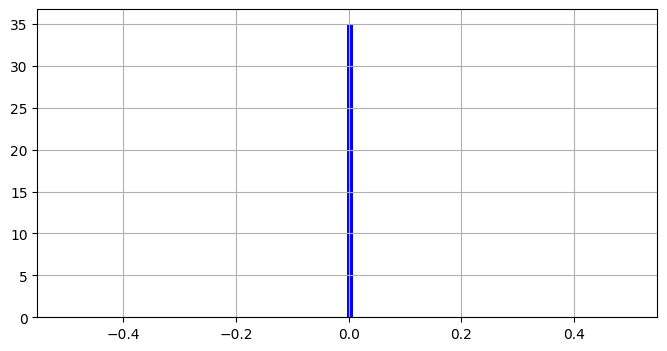

In [54]:
# create histogram for one column
col_nr = 490
df_small.loc[df_small["ground_truth"]==1 , col_nr].hist(bins=100, figsize=(8, 4), color='red')
df_small.loc[df_small["ground_truth"]==0 , col_nr].hist(bins=100, figsize=(8, 4), color='blue')


### Analysis with mean of histogram

In [55]:
# calculate difference between the two histograms
diff = np.abs(df_small.loc[df_small["ground_truth"]==1 , col_nr].mean() 
              - df_small.loc[df_small["ground_truth"]==0 , col_nr].mean())
print(f"difference between the two histograms: {diff}")

difference between the two histograms: 4.336808689942018e-19


column number = 4582, difference = 1.3589808611191958
column number = 3744, difference = 1.168438397891629
column number = 3043, difference = 1.132177772630114
column number = 3766, difference = 1.073818456988875
column number = 4563, difference = 1.0610704955288832
column number = 3767, difference = 1.0273598327845825
column number = 4222, difference = 0.9635838830435236
column number = 2664, difference = 0.898816693762639
column number = 3900, difference = 0.8858654428499754
column number = 3784, difference = 0.8814177314335522


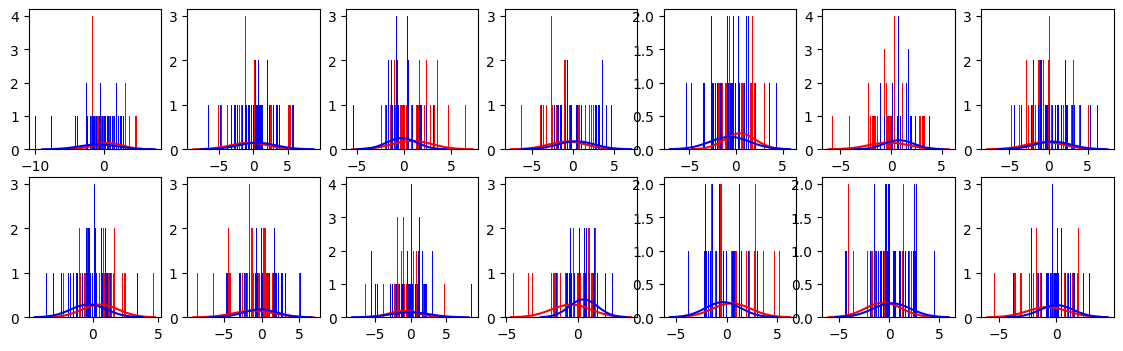

In [56]:
# find the columns with the biggest difference
diff_dict = {}
for col in range(df_small.shape[1] - 1):  # -1 because the last column is the ground truth
    diff = np.abs(df_small.loc[df_small["ground_truth"]==1 , col].mean() 
                  - df_small.loc[df_small["ground_truth"]==0 , col].mean())
    diff_dict[col] = diff
diff_list = sorted(diff_dict.items(), key=lambda x:x[1], reverse=True)  # creates a list of tuples

# print the first 10 pairs of the diff_dict
for i in range(10):
    print(f"column number = {diff_list[i][0]}, difference = {diff_list[i][1]}")

# plot the 10 columns with the biggest difference
fig = plt.figure(figsize=(14, 4))
for i in range(14):
    col = diff_list[i][0]
    ax = fig.add_subplot(2, 7, i+1)
    ax.hist(df_small.loc[df_small["ground_truth"]==1 , col], bins=100, color='red')
    ax.hist(df_small.loc[df_small["ground_truth"]==0 , col], bins=100, color='blue')
    # add bell curve
    mu = df_small.loc[df_small["ground_truth"]==1 , col].mean()
    sigma = df_small.loc[df_small["ground_truth"]==1 , col].std()
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    ax.plot(x, norm.pdf(x, mu, sigma), color='red')
    mu = df_small.loc[df_small["ground_truth"]==0 , col].mean()
    sigma = df_small.loc[df_small["ground_truth"]==0 , col].std()
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    ax.plot(x, norm.pdf(x, mu, sigma), color='blue')
plt.show()


### Analysis with diff of cumulative histogram

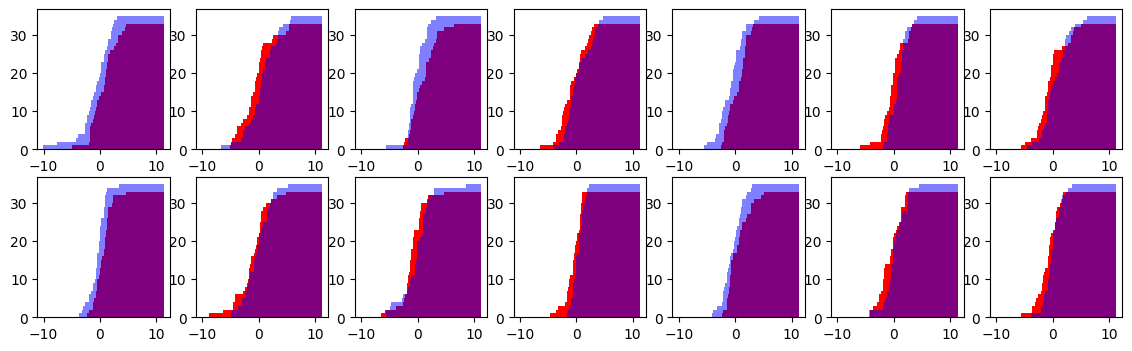

In [57]:
# min and max values of the entire array to set the same range for all histograms (to make sure the binning is the same)
max_value = np.max(df_small.iloc[:, :-1].values)
min_value = np.min(df_small.iloc[:, :-1].values)

# create a cumulative histogram
fig = plt.figure(figsize=(14, 4))
for i in range(14):
    col = diff_list[i][0]
    ax = fig.add_subplot(2, 7, i+1)
    ax.hist(df_small.loc[df_small["ground_truth"]==1 , col], 
            bins=100, color='red', cumulative=True, range=(min_value, max_value))
    ax.hist(df_small.loc[df_small["ground_truth"]==0 , col], 
            bins=100, color='blue', cumulative=True, range=(min_value, max_value), alpha=0.5)
plt.show()

In [65]:
# calculate the difference between the two cumulative histograms including 
# a resampling (done with the range argument) so that the two histograms have the same bins
cum_diff_dict = {}
for col in df_small.columns[:-1]:  # -1 because the last column is the ground truth
    cum_diff = np.abs(np.cumsum(np.histogram(df_small.loc[df_small["ground_truth"]==1 , col],
                                                bins=100, density=True,
                                                range=(min_value, max_value)  # resample to have same binning
                                                )[0])
                    - np.cumsum(np.histogram(df_small.loc[df_small["ground_truth"]==0 , col],
                                                bins=100, density=True,
                                                range=(min_value, max_value)  # resample to have same binning
                                                )[0]))
    cum_diff_dict[col] = cum_diff.sum()
cum_diff_list = sorted(cum_diff_dict.items(), key=lambda x:x[1], reverse=True)  # creates a list of tuples

# print the first 10 pairs of the diff_dict
for i in range(20):
    print(f"column number = {cum_diff_list[i][0]}, area of diff. = {cum_diff_list[i][1]}")

column number = 4582, area of diff. = 29.19499737561958
column number = 3744, area of diff. = 28.549467604693938
column number = 3043, area of diff. = 26.357102344947712
column number = 4563, area of diff. = 25.435496948721163
column number = 3767, area of diff. = 24.444872646169266
column number = 3784, area of diff. = 23.848062103238227
column number = 3766, area of diff. = 23.47454802194843
column number = 4222, area of diff. = 22.755939409031505
column number = 3787, area of diff. = 22.24438751509084
column number = 2664, area of diff. = 19.901804635695385
column number = 4165, area of diff. = 19.62572901039404
column number = 3786, area of diff. = 19.374012999089842
column number = 3407, area of diff. = 19.2684546717687
column number = 3900, area of diff. = 19.26439473610263
column number = 3024, area of diff. = 19.150716537448947
column number = 4990, area of diff. = 19.13447679478446
column number = 3899, area of diff. = 19.053278081460405
column number = 3785, area of diff. = 1

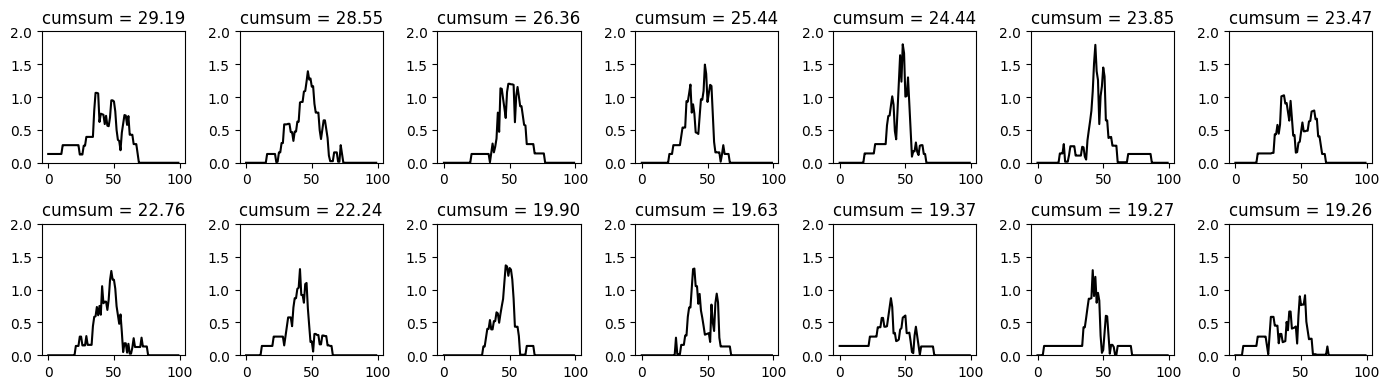

In [63]:
fig = plt.figure(figsize=(14, 4))
for i in range(14):
    col = cum_diff_list[i][0]
    ax = fig.add_subplot(2, 7, i+1)
    diff = np.abs(np.cumsum(np.histogram(df_small.loc[df_small["ground_truth"]==1 , col], 
                                         bins=100, density=True, 
                                         range=(min_value, max_value)  # resample to have same binning
                                         )[0]) 
                  - np.cumsum(np.histogram(df_small.loc[df_small["ground_truth"]==0 , col], 
                                           bins=100, density=True,
                                           range=(min_value, max_value)  # resample to have same binning
                                           )[0]))
    ax.plot(diff, color='black')
    ax.set_title(f"cumsum = {diff.sum():.2f}")
    ax.set_ylim(0, 2)
    fig.tight_layout()
plt.show()

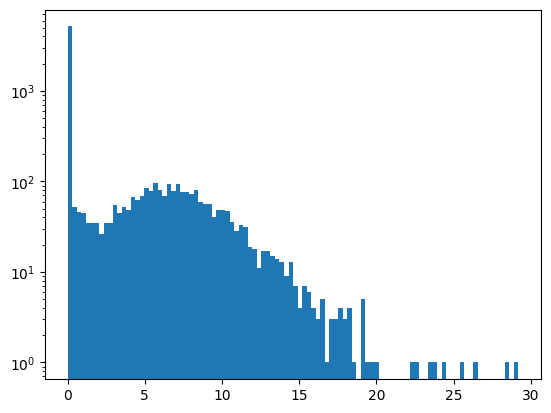

In [60]:
# plot histogram of cum_diff_list
plt.hist([x[1] for x in cum_diff_list], bins=100, log=True);

In [40]:
# FIXME output shows not what I expected

# create and print list of columns with the biggest difference
feature_list = [cum_diff_list[i][0] for i in range(20)]
print(diff_list)

feature_list_values = [cum_diff_list[i][1] for i in range(20)]
print(feature_list_values)


[(4582, 1.3589808611191958), (3744, 1.168438397891629), (3043, 1.132177772630114), (3766, 1.073818456988875), (4563, 1.0610704955288832), (3767, 1.0273598327845825), (4222, 0.9635838830435236), (2664, 0.898816693762639), (3900, 0.8858654428499754), (3784, 0.8814177314335522), (3899, 0.8674894863784982), (3024, 0.8462784065493862), (4165, 0.8413475939058395), (3482, 0.8109008222839964), (3805, 0.8025356738860934), (2928, 0.8008393520370463), (6179, 0.7883201857740694), (3881, 0.7790878738248824), (4990, 0.7757360497289643), (3786, 0.7727734738238978), (3833, 0.7688644040819603), (2613, 0.7659382581071859), (3121, 0.765575825936345), (2927, 0.7647630806182955), (4586, 0.7619166763886442), (4562, 0.7617380285329542), (2588, 0.760821143444006), (3012, 0.7574568235438763), (5408, 0.7464047375926104), (6123, 0.7353563807092269), (4583, 0.7349389161128745), (3787, 0.7347133914903263), (5401, 0.7138057904350017), (4143, 0.7112793944420803), (3814, 0.7083818922094138), (4280, 0.7036031989756097